<a href="https://colab.research.google.com/github/kdemertzis/EKPA/blob/main/Adversarial_Defence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#εγκατάσταση πακέτου ART - Adversarial Robustness Toolbox (https://github.com/Trusted-AI/adversarial-robustness-toolbox)
!pip install adversarial-robustness-toolbox
#***ΠΡΟΣΟΧΗ*** μετά την εγκατάσταση χρειάζεται restart το session
#***θα σας ζητηθεί επανεκκίνηση με σχετικό κόκκινο μήνυμα μετά την ολοκλήρωση της εγκατάστασης
#***Πατήστε το κουμπί RESTART SESSION στο σχετικό μήνυμα

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 28.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.17.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


Batch 1 - Clean Accuracy: 0.48120300751879697, Defended Accuracy: 0.47368421052631576
Batch 2 - Clean Accuracy: 0.48872180451127817, Defended Accuracy: 0.5263157894736842
Batch 3 - Clean Accuracy: 0.5488721804511278, Defended Accuracy: 0.5112781954887218
Batch 4 - Clean Accuracy: 0.5338345864661654, Defended Accuracy: 0.49624060150375937
Batch 5 - Clean Accuracy: 0.5263157894736842, Defended Accuracy: 0.5263157894736842
Batch 6 - Clean Accuracy: 0.518796992481203, Defended Accuracy: 0.5488721804511278
Batch 7 - Clean Accuracy: 0.45112781954887216, Defended Accuracy: 0.47368421052631576
Batch 8 - Clean Accuracy: 0.5413533834586466, Defended Accuracy: 0.46616541353383456
Batch 9 - Clean Accuracy: 0.48120300751879697, Defended Accuracy: 0.5413533834586466
Batch 10 - Clean Accuracy: 0.45112781954887216, Defended Accuracy: 0.518796992481203
Batch 11 - Clean Accuracy: 0.46616541353383456, Defended Accuracy: 0.48120300751879697
Batch 12 - Clean Accuracy: 0.46616541353383456, Defended Accuracy

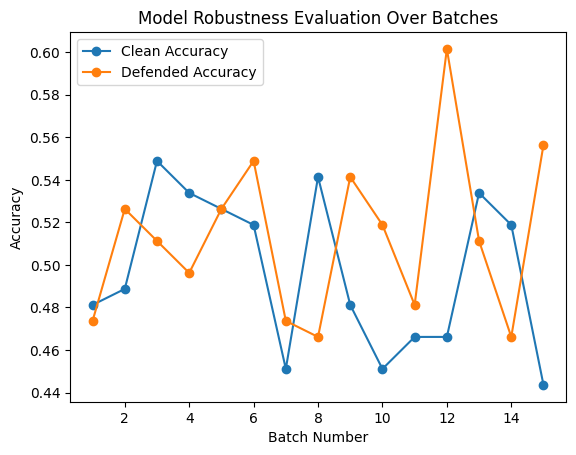

In [12]:
#εισαγωγή βιβλιοθηκών - πακέτων
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from art.estimators.classification import SklearnClassifier
import matplotlib.pyplot as plt

#δημιουργία συνθετικών δεδομένων κυβερνοασφάλειας
np.random.seed(42)
X = np.random.rand(10000, 20)  #10000 περιπτώσεις με 20 μεταβλητές
y = np.random.randint(2, size=10000)  #πρόβλημα δυαδικής ταξινόμησης (binary classification)

#τμηματοποίηση δεδομένων σε σύνολα εκαπίδευσης και δοκιμών
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#εκπαίδευση του κατηγοριοποιητή RandomForest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

#μετατροπή του RandomForestClassifier σε συμβατό format με την ART
art_classifier = SklearnClassifier(model=clf, clip_values=(0, 1))

#υπολογισμός μέση τιμής (mean) και τυπικής απόκλισης (standard deviation) στα καθαρά δεδομένα εκπαίδευσης
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

#προσομοίωση αντιπαραθετικών επιθέσεων σε πραγματικό χρόνο
num_batches = 15
batch_size = len(X_test) // num_batches

#αρχικοποίηση παρακολούθησης μετρήσεων
clean_accuracies = []
defended_accuracies = []

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    X_batch = X_test[start_idx:end_idx]
    y_batch = y_test[start_idx:end_idx]

    #εφαρμογή άμυνας με την προσθήκη Gaussian θορύβου
    noise = np.random.normal(loc=0, scale=0.1, size=X_batch.shape)
    X_defended_batch = X_batch + noise
    X_defended_batch = np.clip(X_defended_batch, 0, 1)

    #αξιολόγηση μοντέλου στην καθαρή και την ro;h (batch) άμυνας
    y_pred_batch = np.argmax(art_classifier.predict(X_batch), axis=1)
    clean_accuracy_batch = accuracy_score(y_batch, y_pred_batch)

    y_pred_defended_batch = np.argmax(art_classifier.predict(X_defended_batch), axis=1)
    defended_accuracy_batch = accuracy_score(y_batch, y_pred_defended_batch)

    #υπολογισμός μετρικών
    clean_accuracies.append(clean_accuracy_batch)
    defended_accuracies.append(defended_accuracy_batch)

    print(f"Batch {i + 1} - Clean Accuracy: {clean_accuracy_batch}, Defended Accuracy: {defended_accuracy_batch}")

#οπτικοποίσηση μετρικών για κάθε ροή δεδομένων (batch)
plt.plot(range(1, num_batches + 1), clean_accuracies, label='Clean Accuracy', marker='o')
plt.plot(range(1, num_batches + 1), defended_accuracies, label='Defended Accuracy', marker='o')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.title('Model Robustness Evaluation Over Batches')
plt.legend()
plt.show()
